In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixedEffects(BaseModel):
    LINK = "mixed_effects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(5, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

        """ Random Effects (Delta) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_delta", n_delta):
                a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 10))
                a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_random = numpyro.sample("a_random", dist.Normal(a_random_mean, a_random_scale))

                    """ Penalty """
                    penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
                    numpyro.factor("penalty_for_negative_a", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(10))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(30))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )

In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/intraoperative/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "midline-lateral", "all-muscles")
config.RESPONSE = ["Triceps", "APB", "ADM"]

config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000
config.MCMC_PARAMS["num_chains"] = 12

model = MixedEffects(config=config)


2023-11-21 11:49:43,080 - hbmep.config - INFO - Verifying configuration ...
2023-11-21 11:49:43,080 - hbmep.config - INFO - Success!
2023-11-21 11:49:43,096 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
df = pd.read_csv(src)

df[model.features[0]] = df[model.features[0]].replace({"L": "01_L", "M": "02_M"})

ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-11-21 11:49:43,190 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles
2023-11-21 11:49:43,191 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles
2023-11-21 11:49:43,192 - hbmep.dataset.core - INFO - Processing data ...
2023-11-21 11:49:43,193 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-21 11:49:43,263 - hbmep.model.baseline - INFO - Running inference with base_model ...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [7]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-21 13:53:34,743 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


2023-11-21 13:54:12,640 - hbmep.utils.utils - INFO - func:predict took: 37.90 sec
2023-11-21 13:54:12,640 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-21 13:54:28,679 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles/recruitment_curves.pdf
2023-11-21 13:54:28,680 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 16.04 sec
2023-11-21 13:54:28,680 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-21 13:54:54,002 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles/posterior_predictive_check.pdf
2023-11-21 13:54:54,003 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 25.32 sec
2023-11-21 13:54:54,003 - hbmep.utils.utils - INFO - func:render_predictive_check took: 25.32 sec


Text(0.5, 1.0, '0.9990833333333333')

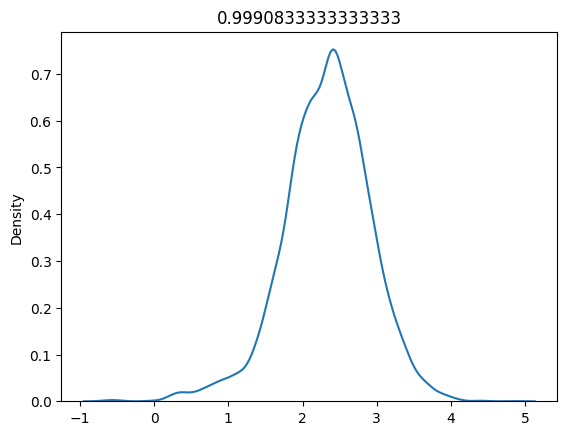

In [18]:
a_random_mean = posterior_samples["a_random_mean"]
a_random_mean.shape


import seaborn as sns
import matplotlib.pyplot as plt

muscle_ind = 0
a_random_mean = posterior_samples["a_random_mean"]

samples = a_random_mean[:, 0, muscle_ind]
sns.kdeplot(samples)
plt.title((samples > 0).mean())


In [15]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data, var_name=site.obs)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data, var_name=site.obs)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")


2023-11-20 14:01:35,168 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-20 14:02:32,750 - __main__ - INFO - ELPD

In [14]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)


In [15]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles/inference.pkl'

In [16]:
dest = os.path.join(model.build_dir, "inference.nc")
az.to_netcdf(mcmc, dest)


'/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles/inference.nc'